In [97]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [98]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [99]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [100]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
conn = engine.connect()

In [101]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

C:\Users\lsemp\AppData\Local\Temp\ipykernel_10048\1652790876.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect=True)


In [102]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [103]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [104]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [105]:
# Find the most recent date in the data set.
maxdate = session.query(func.max(Measurement.date)).scalar() #scalar() to retrieve just the value of the max date directly
most_recent_date = session.query(Measurement).filter(Measurement.date == maxdate).first()

print(f"Most Recent Date: {most_recent_date.date}")

Most Recent Date: 2017-08-23


Recent date:2017-08-23


Text(0.5, 1.0, 'Precipitation by Date')

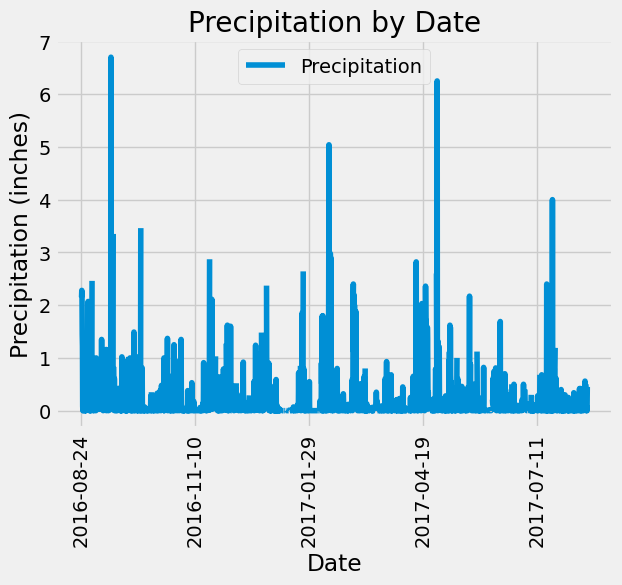

In [106]:
import datetime as dt
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Your existing code to retrieve the most recent data point (assuming it's fixed)

# Assuming 'date' is the column name in the Measurement table
recent_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Extract the date from the Row object (ensure 'date' is the correct column name)
recent_date = recent_data_point[0]  # Access the first element (assuming 'date' is at index 0)
print(f"Recent date:{recent_date}")

# Calculate the date one year ago

year_ago = datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve precipitation data for the last year
date_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago)

# Save the query results as a Pandas DataFrame using SQLAlchemy's read_sql method
date_precipitation_df = pd.read_sql(date_precipitation.statement, session.get_bind())

# Optionally rename columns for clarity
date_precipitation_df = date_precipitation_df.rename(columns={"date": "Date", "prcp": "Precipitation"})

# Sort DataFrame by 'Date'
date_precipitation_df = date_precipitation_df.sort_values(by='Date')
date_precipitation_df.head()

# Create the precipitation plot using Matplotlib
date_precipitation_df.plot(x="Date", y="Precipitation", rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation by Date')


#save figure


In [107]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [108]:
# Design a query to calculate the total number of stations in the datasetMeasurement = base.classes.measurement
Station = base.classes.station

total_num_stations = session.query(Station.station).count()
print(f"Total number of stations in the database is: {total_num_stations}")

Total number of stations in the database is: 9


In [109]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Station.station, func.count(Measurement.station)) \
                        .join(Measurement, Station.station == Measurement.station) \
                        .group_by(Station.station) \
                        .order_by(func.count(Measurement.station).desc()) \
                        .all()

# Print the results for station_id, count
for station_id, count in most_active_stations:
    print(f"Station {station_id}: {count} observations")


Station USC00519281: 2772 observations
Station USC00519397: 2724 observations
Station USC00513117: 2709 observations
Station USC00519523: 2669 observations
Station USC00516128: 2612 observations
Station USC00514830: 2202 observations
Station USC00511918: 1979 observations
Station USC00517948: 1372 observations
Station USC00518838: 511 observations


In [110]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
for min_temp, max_temp, avg_temp in temps:
    print(f"Lowest Temperature: {min_temp}")
    print(f"Highest Temperature: {max_temp}")
    print(f"Average Temperature: {avg_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


Text(0.5, 0, 'Temperature')

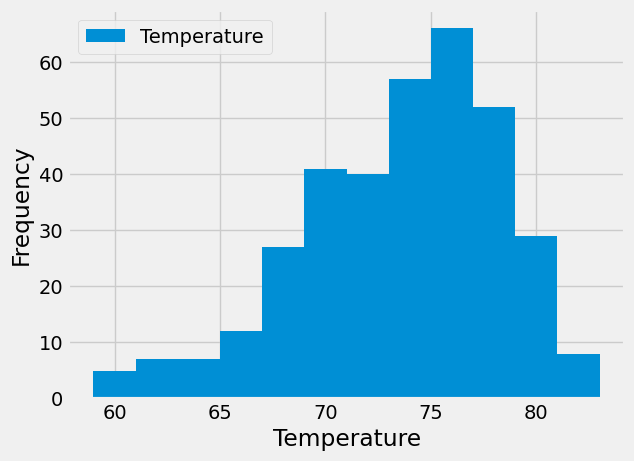

In [112]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_temp = session.query(Measurement.date, Measurement.tobs).\
                                    filter(Measurement.date >= year_ago).\
                                    filter(Measurement.station == "USC00519281")

active_station_df = pd.DataFrame(active_station_temp, columns=["Date", "Temperature"])
    
# plot dates as histogram
active_station_df.plot.hist(bins=12)
plt.xlabel('Temperature')

# Close Session

In [113]:
# Close Session
session.close()